In [1]:
import warnings
warnings.filterwarnings("ignore")
#for handling RAM
import gc 
import cv2
#stats
#from statsmodels.stats.anova import AnovaRM
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from statsmodels.formula.api import ols
#import pingouin as pg


#my to go packages
import math
import random
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
from matplotlib import cm


#for readin
import glob # Package for Unix-style pathname pattern expansion
import os   # Python operating system interface

#for signal processing
from scipy.interpolate import CubicSpline,interp1d
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal import filtfilt, butter
from scipy.fft import rfft, rfftfreq
from scipy.stats import sem 
from scipy.stats import norm
from scipy.stats import ttest_rel
import scipy.io

#other packages
import ast
import itertools
from itertools import groupby
from more_itertools import consecutive_groups
import more_itertools as mit
from operator import itemgetter
import statistics
from sklearn.mixture import GaussianMixture

import pickle
from scipy.ndimage import gaussian_filter


In [2]:
# functions# functions
#helper functions for speed array
def find_abs_speed_noSmooth(timepoint,ps): #find the raw speed array without applying any smoothing

    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        ps = ps.values
        timepoint = timepoint.values
    except AttributeError:
        pass

    prev = abs((ps[1:-1] - ps[0:-2])/(timepoint[1:-1] -timepoint[0:-2]))
    post = abs((ps[1:-1] -ps[2:])/ (timepoint[1:-1] -timepoint[2:]))
               
    ds[1:-1] = np.where(prev >= post,prev,post)
    ds[0] = abs((ps[1] - ps[0])/ (timepoint[1] - timepoint[0]))
    ds[-1] = abs((ps[-1] - ps[-2])/ (timepoint[-1] - timepoint[-2]))
    
    return ds
def find_abs_speed_pup(ps): #this is same as find_abs_speed, but now using a smoothed speed array for pupil
    #by using 5 points to calculate speed instead of 2
    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        nminus1 = ps.iloc[1:-3].values
        nplus1 = ps.iloc[3:-1].values
        nminus2 = ps.iloc[0:-4].values
        nplus2 = ps.iloc[4:].values

        ds[0] = abs(ps.iloc[1] - ps.iloc[0])
        ds[1] = abs(ps.iloc[2] - ps.iloc[1])
        ds[-1] = abs(ps.iloc[-1] - ps.iloc[-2])
        ds[-2] = abs(ps.iloc[-2] - ps.iloc[-3])
    except AttributeError:
        nminus1 = ps[1:-3]
        nplus1 = ps[3:-1]
        nminus2 = ps[0:-4]
        nplus2 = ps[4:]

        ds[0] = abs(ps[1] - ps[0])
        ds[1] = abs(ps[2] - ps[1])
        ds[-1] = abs(ps[-1] - ps[-2])
        ds[-2] = abs(ps[-2] - ps[-3])
               
    ds[2:-2] = abs((nplus1 + nplus2- nminus1 - nminus2  )/6)
    
    
    return ds

def find_rel_speed_pup(ps): #this is same as find_abs_speed, but now using a smoothed speed array for pupil
    #by using 5 points to calculate speed instead of 2
    """I use this to handle the joystick shift, for which i filter out returning movement"""
    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        nminus1 = ps.iloc[1:-3].values
        nplus1 = ps.iloc[3:-1].values
        nminus2 = ps.iloc[0:-4].values
        nplus2 = ps.iloc[4:].values

        ds[0] = abs(ps.iloc[1] - ps.iloc[0])
        ds[1] = abs(ps.iloc[2] - ps.iloc[1])
        ds[-1] = abs(ps.iloc[-1] - ps.iloc[-2])
        ds[-2] = abs(ps.iloc[-2] - ps.iloc[-3])
    except AttributeError:
        nminus1 = ps[1:-3]
        nplus1 = ps[3:-1]
        nminus2 = ps[0:-4]
        nplus2 = ps[4:]

        ds[0] = abs(ps[1] - ps[0])
        ds[1] = abs(ps[2] - ps[1])
        ds[-1] = abs(ps[-1] - ps[-2])
        ds[-2] = abs(ps[-2] - ps[-3])
               
    ds[2:-2] = (nplus1 + nplus2- nminus1 - nminus2  )/6
    
    
    return ds

def find_abs_speed_sacc(vec):#this is same as find_abs_speed, but now using a smoothed speed array,for saccade 
    # because we're using.iloc and .values, need to make sure the 
    # vec input is from dataframe
    try:
        nminus1 = vec.iloc[1:-3].values
        nplus1 = vec.iloc[3:-1].values
        nminus2 = vec.iloc[0:-4].values
        nplus2 = vec.iloc[4:].values
    except AttributeError:
        nminus1 = vec[1:-3]
        nplus1 = vec[3:-1]
        nminus2 = vec[0:-4]
        nplus2 = vec[4:]
    #calculate derivative
    d = (nplus1 + nplus2- nminus1 - nminus2  )/6

    return d
#other helper functions
def consecutive(data, stepsize=10,
                findSame = False): # helper function for findGazeShift, deBlink, and more
    """
    @ data = row vector
    @ stepsize =  the larger the step size, the more difference it allows for two groups
                to be considered within the same cluster
    @ findSame = if True, find concecutive data point of the same value, this is set true
                 for finding blink counts using the blink mask (a df of 0 and 1 )
    """
    # this will split an array of numbers into many subarrays of consecutive numbers
    # the stepsize controls for how close of the two numbers for them to be considered
    # in the same cluster; e.g. [1,2,3,4,5,10] would be clustered together if stepsize = 5

    #data is the array of timepoint where the saccade velocity array crossed the threshold
    if findSame:
        stepsize = 0
        return np.split(data, np.where(abs(np.diff(data)) > stepsize)[0]+1)
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def smooth(x,window_len=11,window='hanning'): #smoothing function
    try:
        x = x.values
    except:
        pass
    # about np windows:
    # https://numpy.org/doc/stable/reference/routines.window.html
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    #this is to prepare the input for convolve i.e. add 1/2 window length padding before and after
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]] 
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    #sliding window
    y=np.convolve(w/w.sum(),s,mode='valid')
    
    #get rid of the paddings
    return y[int(window_len/2):int(-0.5*window_len)] #select the data points to get rid of the delay
def strictly_increasing(L):#check if an array is uniformly increasing
    return all(x<y for x, y in zip(L, L[1:]))
def fs(width,height):#setting plot size
    plt.rcParams['figure.figsize'] = (width,height)

#function used for blink identification
def mad_func(ds,mad_threshold): #calculate the median absolute diviation (MAD)
    
    """
    function that calculate the median absolute diviation (MAD)
    ---------------------------------------------
    input: 
    ds: median absolute dilation speed, which is calculated in dilation_speed_filter
    mad_threshold: the threshold of median deviation (MAD); any data that is above median dilation speed + threshold*(MAD) will be rejected
    ---------------------------------------------
    output:
    returns a float and a boolean, first is the threshold, second is the bool array
    """
    try:
        ds = np.where(np.isnan(ds),0,ds)
    except:
        ds = np.where(ds.isnull(),0,ds)
    mad = np.nanmedian(abs(ds - np.nanmedian(ds))) # median absolute deviation
    rej_threshold = np.median(ds) + mad_threshold * mad # reject data above this threshold
       
    #returning an bool array, true = rejected, false = keep
    return (abs(ds) >= rej_threshold)  , rej_threshold
def reject_outlier(pt,rejarr, minGapLen = 0.03, borderlen = 0.05, borderlenBefore = 0,
                   freq = 1000): # 
    """
  
    ---------------------------------------------
    input:
    pt: pupil timestamps from pup_raw
    rejarr: pupil diameter with nans, assigning nan to the pupil array using the output of dilation_speed_filter()
    ---------------------------------------------
    output: return a dictionary, each key is the starting time of the nan value, each value is the end time of nan
    
    """
    borderN = borderlen* freq #number of adjacent data points that needs to be rejected
    borderNbefore = borderlenBefore * freq
    gapMinN = minGapLen * freq #number of data points in the gap
    
    b = np.where(rejarr==True, np.nan,rejarr)
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0,True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask =  np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_count = count[valid_mask]
    m = out_idx + out_count-1
    out = list(zip(out_idx, m))

    if len(out) == 0:
        return out

    #if the number of consecutively rejected data satisfies as a gap, record it
    outbool = np.array([(out[i][-1] - out[i][0])> gapMinN for i in range(len(out))])
    conRejarr = np.array(out)[outbool]
    gapCorrarr = [[]]*len(conRejarr)
    
    for i in range(len(conRejarr)):
        conRejarr[i][0] = max(0,conRejarr[i][0]-borderNbefore)
        #print(conRejarr[i][-1],conRejarr[i][-1]+borderN)
        conRejarr[i][-1] = min(len(pt)-1,conRejarr[i][-1]+borderN)
        gapCorrarr[i] = np.arange(conRejarr[i][0],conRejarr[i][-1]+1)
   
    return np.array(gapCorrarr,dtype = object)
def blkLen(rowInput,blkLen):#counts how many blink has occured using the mask df
    #blink len default = how many consecutive points for one event to be registered as blink
    #count this as 1 blink event
    boolMask = [list(g)[0]>0 for k, g in groupby(rowInput) ]
    repeatingVal = np.array([list(g) for k, g in groupby(rowInput)])
    
    blkArr = repeatingVal[boolMask]
    blkCnt = sum([len(i) > blkLen for i in blkArr])
    return blkCnt
def medianVariance(vec):#vec is the result from find_abs_speed_pup/sacc
    try:
        val = np.nanmedian(abs(vec - np.nanmedian(vec)))
    except:
        print('F**k! medianVariance function encountered an error:')
        print('dtype of vec:' + str(type(vec)))
        print('np.nanmedian(vec) :' + str(np.nanmedian(vec)))
    return val
#older functions
def interpolate_blink(paddedRejIndex,paddedRejBool, timestamp,pupilsize,
                      maxGapLen = 0.5,freq = 200):#paddedRejIndex = output from reject_outlier; ..Bool is the pseudodf['paddedDsRej']
    # check for the length for each gap, if it's longer than the maximum length defined for a gap
    # then don't interpolate, just leave it blank
    interpolateIndex = paddedRejIndex[[len(i)<maxGapLen*freq for i in paddedRejIndex]]
    """ i found that it works better to not smooth the pupil size
     """
    pupilsize = np.array(smooth(pupilsize))
   
    #for each blink, select the onset/offset pupil size, as well as two equal distant time point,call it ref list
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(timestamp)-1,i[-1] + len(i))]) for i in interpolateIndex])
    
    #use the refList to retrieve the paddedRejIndex, if more than 2 values are True, i.e. the first and last reference points
    #are also rejected data, then use the linear interpolation, else if the first and last ref points can be retrieved,
    #use cubic spline interpolation
    linearList = refList[np.sum(paddedRejBool.values[refList],axis = 1) > 2]
    cubicList = refList[np.sum(paddedRejBool.values[refList],axis = 1)== 2]
    
    #use the linearlist or cubic list, find the timestamp or pupilsize values used for interpolation
    cubictss = timestamp.values[cubicList]
    cubicarr = pupilsize[cubicList]#pupilsize.values[cubicList]
    
    lineartss = timestamp.values[linearList]
    lineararr = pupilsize[linearList]#pupilsize.values[linearList]
    
    #calculate the interpolated values; Index is the array of timestamp arrays, FuncList is the interpolated value
    cubicIndex = [np.array(timestamp.iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(timestamp.iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]
   
    return cubicIndex,csFuncList,linearIndex,lFuncList
def dsclean(thisdf,arr):
    """
    this is the main function for reject, clean, and interpolate
    thisdf is the df of the specific subject
    #1st it, arr = 'diameter_3d', 2+ it, arr = 'diameter_3dNew'
    
    note: outside the function, these four variables needs to be specified, e.g.
    maxGapLen = 1; minGapLen = 0.0 ; freq = 1000; gapMinN = minGapLen*freq; gapMaxN = maxGapLen*freq
    
    
    """
    #1st ite
    arr = thisdf[arr] #1st it, arr = diameter_3d, 2+ it, arr = diameter_3dNew
    rejarr,rejThreshold = mad_func(find_abs_speed(thisdf.pupil_timestamp,arr),3.5)    #need to get rid of zeros
    thisdf['dsRej'] = (rejarr == True) | (arr.isnull()) | (arr == 0)

    paddedDsRej = reject_outlier(thisdf.pupil_timestamp,thisdf.dsRej,minGapLen = minGapLen,borderlen=0.025,freq= 1000)
    thisdf['paddedDsRej'] = np.where(thisdf.index.isin(np.concatenate(paddedDsRej)),True,False)

    gapCorrarr = np.where(thisdf.paddedDsRej)[0]
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = [np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)] 

    #if the gap is shorter than minimum length, don't count it as a gap (but i've set min gap len to 0)
    outbool = np.array([(gapCorrarrParsed[i][-1] - gapCorrarrParsed[i][0])> gapMinN for i in range(len(gapCorrarrParsed))])
    gapCorrarrParsed = np.array(gapCorrarrParsed)[outbool]
    #correct the paddedDsRej, excluding shorter-than-gap values, i.e. set those to false
    thisdf['paddedDsRejNoGap'] = np.where(thisdf.index.isin(np.concatenate(gapCorrarrParsed)),True,False)

    #also don't interpolate for gap length longer than maximum gap len
    #first iteration use diameter 3d
    csts,csi,lts,li = interpolate_blink(paddedRejIndex = gapCorrarrParsed,
                                        paddedRejBool = thisdf['paddedDsRejNoGap'],
                                        timestamp = thisdf.pupil_timestamp,
                                        pupilsize = arr,
                                        freq = 1000) #this pupilsize is different for iteretions

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf['diameterThisIter'] = arr #this pupilsize is different for iteretions
    try:
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(csts)))[0],'diameterThisIter'] = np.concatenate(csi)
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(lts)))[0],'diameterThisIter'] = np.concatenate(li)
    except ValueError: 
        print('no array to concat')
    """
    minPup = np.mean(thisdf['diameterThisIter']) - 3*np.std(thisdf['diameterThisIter'])
    maxPup = np.mean(thisdf['diameterThisIter']) + 3*np.std(thisdf['diameterThisIter'])

    #also reject periods of pupil size that's larger the 3 sd away from the median, callit diameter_3dNew
    thisdf['diameter_3dNew'] = np.where(((thisdf['diameterThisIter']<minPup)|(thisdf['diameterThisIter']>maxPup)),0, thisdf['diameterThisIter'] )
    """
    return thisdf
def tlclean(thisdf,windown = 501,mad = 10,
            psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    thisdf['dsRej'] = (tlmad == True) | (thisdf[psCol].isnull() == True) | (thisdf[psCol] == 0)

    #don't pad the tl deviations
    arr = thisdf[psCol]
    gapCorrarr = (np.where(thisdf.dsRej)[0]) 
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = np.array([np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)]) 

    #preparation for interpolation
    interpolateIndex = gapCorrarrParsed[[len(i)<maxGapLen*freq for i in gapCorrarrParsed]]
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(thisdf[tsCol])-1,i[-1] + len(i))]) for i in interpolateIndex])
    increasingList = np.array([strictly_increasing(i) for i in refList])

    linearList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1) > 2) | (increasingList== False) ]
    cubicList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1)== 2) & (increasingList)]

    #use the linearlist or cubic list, find the thisdf[tsCol] or arr values used for interpolation
    cubictss = thisdf[tsCol].values[cubicList]
    cubicarr = arr.values[cubicList]
    #correct for nan
    cubicList = cubicList[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubictss = cubictss[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubicarr = cubicarr[np.isnan(cubicarr).sum(axis = 1) !=1] ##

    #for linear
    lineartss = thisdf[tsCol].values[linearList]
    lineararr = arr.values[linearList]
    #correct for nan
    linearList = linearList[np.isnan(lineararr).sum(axis = 1) !=1]##
    lineartss = lineartss[np.isnan(lineararr).sum(axis = 1) !=1]##
    linearr = lineararr[np.isnan(lineararr).sum(axis = 1) !=1] ##


    #calculate the interpolated values; Index is the array of thisdf[tsCol] arrays, FuncList is the interpolated value
    cubicIndex = [np.array(thisdf[tsCol].iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(thisdf[tsCol].iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf[psColNew] = arr #copy the old ps column, then modify it using the interpolated values
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(cubicIndex)))[0],psColNew] = np.concatenate(csFuncList)
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(linearIndex)))[0],psColNew] = np.concatenate(lFuncList)
    
    return thisdf
def tl(thisdf,windown = 501,mad = 10,
       psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    return tlmad
def tlFinal(x,y,windown = 101,mad = 10):
    #this is for doing trialwise tl rejection, not very necessay but since the input format
    #is slightly different from the tl function, i'm including it as a sepearte one
    cs = CubicSpline(x[~np.isnan(y)],
                    y[~np.isnan(y)])
    interp = cs(x)
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(y-smoothed,mad)[0]
    return tlmad

def findGazeShift(xvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 2.14,):
    """
    @ xvec =  the gaze position (it should be each row in the saccRetro_X df)
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if none, calculate relative baseline  (i.e. in regard to position before and after shift)
                else it should be a list of index to indicate baseline rage, e.g. [500,1000]
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 2.14 pixel = 0.057 visual degree
    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_sacc(xvec)
    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = [np.nanmedian(dx) + medianVariance(dx) *threshold,np.nanmedian(dx) - medianVariance(dx) *threshold]
    cx = (dx>thresholdx[0]) | (dx < thresholdx[1])
    cx = np.r_[False,False,cx,False,False] #correct for the four lost points


    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen),np.ones(len(cx) - 3*winlen),np.zeros(2*winlen)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)

    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))    

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen,i[0]]
            else:
                befIndex = baseline
            try:
                posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec.iloc[i[0] + winlen : i[0] + 2*winlen]) 

            except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec[i[0] + winlen : i[0] + 2*winlen]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift
#this is originally used to linearly interpolate 
#missing saccade data
#this is originally used to linearly interpolate 
#missing saccade data
def linearInterpolate(x,y,method = 'linear'):
    """
    methods needs to be one of the scipy.interpolate.interp1d methods
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
    """
    #if the entire trial is nan, return nan
    if np.isnan(np.array(y)).sum() == len(y):
        interp = np.empty(len(y))
        interp[:] = np.nan
        return interp
    #else,interpolate
    try:
        li = interp1d(x[~y.isnull()],
                        y[~y.isnull()],
                        fill_value="extrapolate",kind = method)
        interp = li(x)
    except AttributeError: #handling np.array and pandas df conversion
        li = interp1d(x[~np.isnan(y)],
                        y[~np.isnan(y)],fill_value="extrapolate",kind = method)
        
    interp = li(x)
    return interp
#plotting function
def legend_without_duplicate_labels(ax,locVal = 'best'):
    #https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc = locVal)
def deBlinkSample(rawPup, samplesize = 10,**kwargs): #plot n trial samples with the deblink process
    fs(12,12)
    select = np.random.randint(0,len(rawPup),size = samplesize)

    #select some smaple 
    sample_raw = rawPup.iloc[select,1:]

    #Clean once
    if kwargs:
        cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)), **kwargs),axis = 1,raw = True) 
    else:
        cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                clusterLapse = 0.05, borderlenAft = 0.2,
                                                borderlenBef= 0.05,madThreshold = 4),axis = 1,raw = True) 

        

    #second clean
    onceSmoothSample = cleanOnceSample.rolling(11,min_periods=1,center  = True,axis =1).mean()
    cleanTwiceSample = onceSmoothSample.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 6),axis =1,raw = True)
    fig,ax = plt.subplots(nrows = 3)

    x = np.linspace(0,5,5000)
    [ax[0].plot(x,sample_raw.iloc[i,:],alpha = 0.8) for i in range(len(select))]
    [ax[1].plot(x,cleanOnceSample.iloc[i,:],alpha = 0.84,linewidth = 2) for i in range(len(select))]
    [ax[2].plot(x,cleanTwiceSample.iloc[i,:],alpha = 0.8,linewidth = 2) for i in range(len(select))]

    ax[1].set_ylim(ax[2].get_ylim())
    ax[0].set_ylim(ax[2].get_ylim())

    plt.show()
def pupilPlot(normPup,blPup, 
              eventt = 3,
              blt  = 0.1,
              freq = 1000,
              type = 'grand',
              levels = ['cue_blk_validity','cued_item'],
              pltRatio = [0.2,3], pltN = 3,
              eventBoundary = [0,0.5,2.5],
              eventName = ['retrocue','delay','probe'],
              blHeight = None,
              cList = [],
              figH = 5.5, figW = 16,
              tightPlot = True,
              textSize = 12,
              ):
    """
    @ normPup = normalized pupil df with trial info columns in the end
    @ blPup = the pupil df with the baseline
    @ eventt = the time for the event of interest
    @ blLen = the time for the baseline
    @ freq = sampling frequency, defalut 1000
    @ type = the type of plot, 
           - grand avg: ;
           - subj avg: ;
    @ levels = the group by levels, e.g. block validity and cued item
    @ pltRatio = ratio for the plot for baseline and event
    @ pltN = how many plots, default 3
    @ eventBoundary = use to plot vertical lines on the plot to represent certain events
    @ eventName = the text label for these events
    @ blHeight = ylim for the baseline plots, if None, set ylim using max and min
    @ cList = the color list used for plots; default color- the ones i carefully preseletced, very pretty
    @ figH = figure height for each plot, default 5.5
    @ figW = figure width, default 16
    @ tightPlot = if true, set the plot layout to be tighter
    @ textSize = the text label on the plot size
    --------------
    return NormMean: the groupby df
    """
    eventLen = int(eventt*freq)
    blLen = int(blt*freq)

    if not type in ['grand','subj']:
        raise 'Your plot should either be grand avg or subj avg'
    if len(eventBoundary) != len(eventName):
        raise 'your event name array should be the same size as your event boundary(time) array'
    if type == 'grand':
        normmean = normPup.groupby(levels).mean().iloc[:,:eventLen]
        norm_sterr = normPup.groupby(levels).sem().iloc[:,:eventLen]
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 

        normmeanBL = blPup.groupby(levels).mean().iloc[:,:blLen]
        norm_sterrBL = blPup.groupby(levels).sem().iloc[:,:blLen]
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the mean df will be returned
        returnMean = normmean    
        returnSd = norm_sterr
    elif type == 'subj':
        subj_levels = levels + ['subj']
        normmean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).mean()
        norm_sterr = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).sem()
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        
        normmeanBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).mean()
        norm_sterrBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).sem()
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the subj df will be returned
        returnMean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen]
        returnSd =  normPup.groupby(subj_levels).sem().iloc[:,:eventLen]

    condN = normmean.shape[0]
    #if color list is not right length, use sns generated color
    if len(cList) < condN:
        print('input color list is too short, plot default color ')
        cList = sns.color_palette("flare",n_colors = condN)
     
    #setting up plotting params
    fs(figW,pltN*figH) #set figure size
    fig,ax = plt.subplots(nrows= pltN, ncols=2, sharex=False, sharey = False,
                          gridspec_kw={'width_ratios': pltRatio,})
    x = np.linspace(0,eventt,norm_sterr.shape[1])
    xBL = np.linspace(0,blt,norm_sterrBL.shape[1])
    if blHeight == None:
        blHeight = [norm_lowerBL.min().min(), norm_upperBL.max().max()]

    #plot mean plot for the baseline and for the trial
    [ax[i//2][0].fill_between(xBL,norm_upperBL.iloc[i,0:norm_sterrBL.shape[1]],norm_lowerBL.iloc[i,0:norm_sterrBL.shape[1]],
                        color = cList[i],alpha = 0.2,)  for i in range(condN)]
    [ax[i//2][0].plot(xBL,normmeanBL.iloc[i,0:norm_sterrBL.shape[1]],linewidth = 2.5,color = cList[i],) for i in range(condN) ]

    [ax[i//2][1].fill_between(x,norm_upper.iloc[i,0:norm_sterr.shape[1]],norm_lower.iloc[i,0:norm_sterr.shape[1]],
                        color = cList[i],alpha = 0.1, )  for i in range(condN)]
    [ax[i//2][1].plot(x,normmean.iloc[i,0:norm_sterr.shape[1]],color = cList[i],linewidth = 2,) for i in range(condN) ]
    [ax[i][0].set_ylim(blHeight) for i in range(pltN)]
    
    #add vertical line and text
    for ff in range(pltN):
        ax[ff][1].vlines(eventBoundary,norm_lower.min().min(),
                         norm_upper.max().max(),linestyles = 'dashed',colors= 'black')
    for i,m in zip(eventBoundary,eventName):
        ax[0][1].text(i,norm_upper.max().max(),m,c = 'black',size = textSize)
    
    #make the plots tighter
    if tightPlot:
        plt.subplots_adjust(hspace = 0.1)
        plt.subplots_adjust(wspace = 0.06)
        
    #plt.xticks(fontsize= figW, )
    plt.show()

    return returnMean,returnSd
# for behavioral response from psychopy

def find_click_time(click,time):
    try:
        rt = time[np.nonzero(click)[0][0]]
    except IndexError:
        rt = np.nan
    return rt
def findGazeShift2d(xvec,yvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 0.2,
                   baselinePadding = 0,shiftWhere = False,):
    """
    @ xvec =  the gaze position horizontal channel
    @ yvec = the gaze position vertical channel
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if ***none***, calculate relative baseline  (i.e. in regard to position before and after shift)
                if ***list***, it indicate baseline rage, e.g. [500,1000]
                if ***numeric***, use the numeric value as baseline
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 0.2% 
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    @ shiftWhere = if True, only return the index where shift occurs. This is useful if use needs to combine
                    the horizontal and vertical gaze arrays. 
                    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_pup(xvec).astype(float)
    dy = find_abs_speed_pup(yvec).astype(float)
    dxySqrt = eDist(dx,dy)

    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = np.nanmedian(dxySqrt) + medianVariance(dxySqrt) *threshold
    cx = dxySqrt>thresholdx
    
    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)
    
    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))   

    # if user only needs to know the location where shift occured, return a boolean array
    # where 1 =  shift occur, 0 = no shift
    if shiftWhere:
        try:
            fillLoc = np.array([i[0] for i in msCluster]) 
            gazeshift[fillLoc] = 1
        except IndexError:
            pass
        return gazeshift

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            
            #calculate gaze position before the shift occured 
            if type(baseline) != int:
                try:
                    posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                    posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
            else: #if user decide to use a numerical value as the baseline, use that
                posbef = baseline

            #calculate the gaze position afte the shift
            try:
                posaft = np.nanmean(xvec.iloc[i[-1] : i[-1] + winlen]) 
            except:    
                posaft = np.nanmean(xvec[i[-1]: i[-1] + winlen]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift

def eDist(a,b): #eucleadian distance
    return np.sqrt(a**2+b**2)

In [3]:
#core functions
def deBlink(rawPup,timestamp,
            returnMask = False,
            maxGapt = 2,
            minGapt= 0.003,
            freq = 1000,
            borderlenBef=0.001,
            borderlenAft=0.01,
            clusterLapse = 0.15,
            plotSteps = False,
            madThreshold = 3.5,
            minAllowedPup = 2000
            ):
    """
    #this function clean the pupil array, and generate a boolean blink mask array
    @ rawPup = each row in the epoched pupil table
    @ timestamp = 
    @ returnMask: if true, return the boolean mask only (this is necessday because df.apply can't return two dfs)
    @ minGapt = 
    @ freq = 
    @ borderlenBef = paddings to add after each blink
    @ borderlenAft = paddings to add before each blink
    @ clusterLapse = larger value will count more distant blinks as one, resulting in more data rejected
    @ plotSteps = if True, generate a plot for the cleaning step
    @ madThreshold = speed threshold for rejection
    """
    #find the raw rej arr; This use a smoothed pupil change speed array to find the threshold
    #crossings
    rejarr = mad_func(find_abs_speed_pup(rawPup),madThreshold)[0] | (rawPup < minAllowedPup)

    #initialize two mask array, these will store the processed blink mask
    rejarr_padded = np.zeros(len(rejarr))
    rejarr_blkMask = np.zeros(len(rejarr))

    #pad the mask
    try:
        temp = np.concatenate(reject_outlier(timestamp, rejarr, minGapLen= minGapt, borderlenBefore=borderlenBef,
                                                    borderlen=borderlenAft))
        
        rejarr_padded[temp.astype(int)] = 1
    except ValueError:
        rejarr_padded = rejarr
       
    
    #identify clusters in the mask (if two blink are too close, count them as one cluster and mask off the lapse between)
    #put the resulting mask into rejarr_blkMask, this will be returned as output
    try:
        consecutiveBlkFilter = np.array([np.arange(i[0], i[-1]+1) for i in consecutive(np.where(rejarr_padded)[0], 
                                                                                       stepsize= clusterLapse*freq)])
        #rejarr_blkMask = np.r_[rejarr_blkMask,np.concatenate(consecutiveBlkFilter)]
        np.put(rejarr_blkMask, np.concatenate(consecutiveBlkFilter), 1, mode='clip')
    except ValueError:
        rejarr_blkMask = rejarr_padded
    except IndexError:
        # if the user want to only return the blink mask, and that no outliter is found
        # return an empty mask, else, return pupil size.
        if returnMask:
            return np.zeros(len(rejarr))
        return rawPup
        
    blkMask = rejarr_blkMask.copy()

    #just return the mask if necessary
    if returnMask:
        return blkMask

    """clean"""
    #use this mask to clean the pupil, mask off the data in blink
    #creating a copy for the plot because we will change the value of maskedPup 
    maskedPup_plt = np.where(rejarr_blkMask, np.nan, rawPup) 
    maskedPup = maskedPup_plt.copy() 

    """interpolation"""
    # reshape the clusted blink mask into arrays of clusted index, if its lenth if larger than the 
    # maximum gap lenth * frequency, then don't interpolate for this cluster, just leave it blank
    rejCluster = consecutive(np.where(rejarr_blkMask)[0], 1)
    rejCluster = np.array([k for k in rejCluster if len(k) < maxGapt*freq],dtype = object)

    #find four index for interpolation
    indexForInterp = np.asarray([np.array([max(0, i[0] - len(i)),
                                        max(0, i[0]-1),
                                        min(i[-1]+1, len(timestamp)-1),
                                        min(len(timestamp)-1, i[-1] + len(i))]) for i in rejCluster],dtype = object).astype(int)
    
    #when applying this function to a df, sometime it required the input to be in specific format
    try:
        timestamp = timestamp.values
        rawPup = rawPup.values
    except AttributeError:
        timestamp = np.array(timestamp)
        rawPup = np.array(rawPup)
    
    #run the following if there there are available blink clusters for interpolation, interpolate
    try:
        #get the timestamp and pupil size (masked) for creating the interpolation function
        
        tsForInterp = timestamp[indexForInterp]
        cleanPupForInterp = maskedPup[indexForInterp]
        
        
        #get the timestemp for exptrapolate the missing pupil size
        tsForExtrap = [timestamp[i] for i in rejCluster]
        
        #for each available blink cluster,try use the cubic spline interpolation of 4 points
        #but if any point if nan, then use linear; but if it still can't (e.g. only one data point availble)
        #then don't interpolate, leave it as nan
        for i in range(len(rejCluster)):
            
            try:
                pupExtrapolated = CubicSpline(tsForInterp[i], cleanPupForInterp[i])(tsForExtrap[i].astype(float))
            except ValueError:
                try:  # if cant find reference points, use linear interpolation
                    pupExtrapolated = interp1d(tsForInterp[i][1:3], cleanPupForInterp[i][1:3])(tsForExtrap[i].astype(float))
                # if still gives error, then dont interpolate (usually the case with trial start/end)
                except ValueError:
                    pupExtrapolated = np.nan
            #fill each blink cluster with interpolated pupil value
            
            maskedPup[rejCluster[i]] = pupExtrapolated
    except IndexError:
        
        pass

    if plotSteps:
        fig, ax = plt.subplots(nrows=5)
        #plot speed and threshold of rejection
        sns.scatterplot(x= timestamp, y= find_abs_speed_pup(rawPup), ax=ax[0])
        ax[0].hlines(mad_func(find_abs_speed_pup(rawPup), 3.5)[1],
                    xmin=timestamp[0], xmax=timestamp[-100], colors='r')
        #plot the unfilted mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr, ax=ax[1])
        #plot the filtered mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr_blkMask, ax=ax[2])
        #plot the pupil data after it's been masked
        sns.scatterplot(x=timestamp, y=maskedPup_plt, ax=ax[3])
        #plot the interpolated pupil size
        sns.scatterplot(x=timestamp, y=maskedPup, ax=ax[4])
        
        ax[1].sharex(ax[0])
        ax[2].sharex(ax[0])
        ax[3].sharex(ax[0])
        ax[4].sharex(ax[0])

    
    return maskedPup

# preprocessing (run only if you'd like to readin/preprocess the data)
- if only need to read in data, jump to "readin gaze data (if applicable)" section

In [4]:
pd.set_option('display.max_columns', 500)

In [ ]:
#read in the mega df
local_username = 'yud070'
pathEL = "Z:/yueying/gazeObject_YueyingDong/data/goRaw_tracker/"
pathpy = "Z:/yueying/gazeObject_YueyingDong/data/goRaw_psychopy/"

readIn = sorted(np.array([f for f in os.listdir(pathEL)]))
readIn

['112430',
 '301',
 '302',
 '303',
 '304',
 '305',
 '306',
 '307',
 '308',
 '309',
 '310',
 '311',
 '312',
 '313',
 '314',
 '315',
 '316',
 '317',
 '318',
 '319',
 '320',
 '321',
 '322',
 '323',
 '324',
 '325',
 '326',
 '327',
 '328',
 '329',
 '330',
 '331',
 '332',
 '333',
 '334',
 '335',
 '336',
 '337',
 '338',
 '339',
 '340',
 '341',
 '342',
 '343',
 '344',
 '345',
 '346',
 '347',
 '348',
 '349',
 '350',
 '351',
 '352',
 '360',
 '362',
 '363',
 '364',
 '365',
 '366',
 '367',
 '368',
 '369',
 '370',
 '371',
 '372',
 '373',
 '374',
 '375',
 '376',
 '377',
 '378',
 '379',
 '380',
 '381',
 '382',
 '383',
 '384',
 '385',
 '386',
 '387',
 '388',
 '389',
 '390',
 '391',
 '392',
 '393',
 '394',
 '395',
 '396',
 '397',
 '398',
 '399',
 '400']

In [ ]:
#experiment specific params

fixation = 500 #1000
stimulus = 1000	
mask = 500
blank = 500
retrocue = 500
delay = 3000	
probe = 3000	
iti = 1000


eventArr = [fixation,stimulus,mask,blank,retrocue,delay]


In [8]:
#columns to readin
relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']
selectEye = 'AVERAGE_PUPIL_SIZE'
included = sum(eventArr)+ 500
included

6500

In [9]:
#record any subject who we only tracked one eye
rightEyeSubj = ['301','323','333','345','347']
leftEyeSubj = ['316','310','321','326','333','334','336','337','340','341','373','396']

In [ ]:
#readIn raw files
runReadin = input()
if runReadin == 'y':
    #for recording everyone's preprocessed data along with saccade tags
    psyFull = pd.DataFrame()

    pupFullTrial_raw = pd.DataFrame()
    saccFullTrial_x_raw = pd.DataFrame()
    saccFullTrial_y_raw = pd.DataFrame()
    for n,f in enumerate(readIn):

        """ section1: read in """
        f = str(f)
        print('start processing: ' + f)

        #readin eyelink file
        el = pd.read_csv(glob.glob(pathEL+ f + '/*.txt')[0]
                ,delimiter = "\t")#encoding = 'utf-16'
    
        #replace non-sensible values with nans
        el['TRIALID'] = el.TRIALID.replace('UNDEFINED',np.nan)
        el = el[~el.TRIALID.isnull()]
        el['SAMPLE_MESSAGE'] = el.SAMPLE_MESSAGE.replace('.',np.nan).ffill()

        #for a few subjs, we only tracked one eye, select this eye's data
        selectEye = 'AVERAGE_PUPIL_SIZE'
        if f in leftEyeSubj:
            selectEye = 'LEFT_PUPIL_SIZE'
        elif f in rightEyeSubj:
            selectEye = 'RIGHT_PUPIL_SIZE'
        elif el.EYE_TRACKED.iloc[0] != 'Binocular':
            selectEye = el.EYE_TRACKED.iloc[0].upper()+ '_PUPIL_SIZE'

        #after reading in el file, transform to trial * timestamp structure
        pseudodf = el 

        pseudodf = pseudodf.rename(columns={selectEye:'pupSize','TIMESTAMP':'pupil_timestamp'}).reset_index(drop = True)
        pseudodf['pupSize'] = pd.to_numeric(pseudodf['pupSize'].replace('.',0))
        pseudodf['AVERAGE_GAZE_X'] = pd.to_numeric(pseudodf['AVERAGE_GAZE_X'].replace('.',np.nan))
        pseudodf['AVERAGE_GAZE_Y'] = pd.to_numeric(pseudodf['AVERAGE_GAZE_Y'].replace('.',np.nan))
        pseudodf['eventOnset'] = pseudodf.SAMPLE_MESSAGE.astype(str) #prepare for index for  epoching
        pseudodf['x'] = pseudodf.groupby('TRIALID').cumcount() #prepare for transformation
    
        #pivot, only keep the data before probe (5s of data = 5000 sample points)
        pupRaw = pd.pivot_table(pseudodf[['x','pupSize','TRIALID']],values = 'pupSize',columns = 'x',index = 'TRIALID').reset_index().iloc[:,:included+1]
        saccAllT_X = pd.pivot_table(pseudodf[['x','AVERAGE_GAZE_X','TRIALID']],values = 'AVERAGE_GAZE_X',columns = 'x',index = 'TRIALID').reset_index().iloc[:,:included+1]
        saccAllT_Y = pd.pivot_table(pseudodf[['x','AVERAGE_GAZE_Y','TRIALID']],values = 'AVERAGE_GAZE_Y',columns = 'x',index = 'TRIALID').reset_index().iloc[:,:included+1]
    
        #concate
        print('     start concate: ' + f)

        #pupil
        pupFullTrial_raw = pd.concat([pupFullTrial_raw,pupRaw])
        #sacc
        saccFullTrial_x_raw = pd.concat([saccFullTrial_x_raw,saccAllT_X])
        saccFullTrial_y_raw = pd.concat([saccFullTrial_y_raw,saccAllT_Y])



In [44]:
psyFull = pd.DataFrame()
conAll = pd.DataFrame()
for f in readIn:
    f = str(f)

    trlInfo = pd.read_csv(glob.glob(pathpy+f+ '/*.csv')[0])
    try:
        trlInfo = trlInfo[(trlInfo.is_practice!=True)& (trlInfo.TRIALID.isnull() == False)]
    except AttributeError:
        trlInfo = trlInfo[(trlInfo.TRIALID.isnull() == False)]
        
    psyFull = pd.concat([psyFull,trlInfo])
psyFull = psyFull.drop_duplicates().reset_index(drop = True)

In [ ]:
try:
    #view distribution of pupil size data
    pupDat = pupFullTrial_raw.iloc[:,1:].values.flatten()
    plt.hist(pupDat,bins = 50)
except NameError:
    pass

# readin pupil and psychopy files

In [9]:
psyFull = pd.DataFrame()
conAll = pd.DataFrame()
for f in readIn:
    f = str(f)

    trlInfo = pd.read_csv(glob.glob(pathpy+f+ '/*.csv')[0])
    try:
        trlInfo = trlInfo[(trlInfo.is_practice!=True)& (trlInfo.TRIALID.isnull() == False)]
    except AttributeError:
        trlInfo = trlInfo[(trlInfo.TRIALID.isnull() == False)]
        
    psyFull = pd.concat([psyFull,trlInfo])
psyFull = psyFull.drop_duplicates().reset_index(drop = True)

In [14]:
try:
    if pupFullTrial_raw.shape[0] == 0:
        pupFullTrial_raw = pd.DataFrame()

        for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/PupRaw_formatted' + '/*.csv')[-4:]:
            pupFullTrial_raw = pd.concat([pupFullTrial_raw,pd.read_csv(i).iloc[:,1:]])
        pupFullTrial_raw = pupFullTrial_raw.reset_index(drop = True)
    else:
        print('no need to read in')
except NameError:
    pupFullTrial_raw = pd.DataFrame()
    for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/PupRaw_formatted' + '/311to352/*.csv')[-4:]:
        pupFullTrial_raw = pd.concat([pupFullTrial_raw,pd.read_csv(i).iloc[:,1:]])
        pupFullTrial_raw = pupFullTrial_raw.reset_index(drop = True)


In [11]:
try:
    if saccFullTrial_x_raw.shape[0] == 0:
        saccFullTrial_x_raw = pd.DataFrame()
        saccFullTrial_y_raw = pd.DataFrame()

        for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted' + '/*x*.csv')[-4:]:
            saccFullTrial_x_raw = pd.concat([saccFullTrial_x_raw,pd.read_csv(i).iloc[:,1:]])
        for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted' + '/*y*.csv')[-4:]:
            saccFullTrial_y_raw = pd.concat([saccFullTrial_y_raw,pd.read_csv(i).iloc[:,1:]])
        
        saccFullTrial_x_raw = saccFullTrial_x_raw.reset_index(drop = True)
        saccFullTrial_y_raw = saccFullTrial_y_raw.reset_index(drop = True)
    else:
        print('no need to read in')
except NameError:
    saccFullTrial_x_raw = pd.DataFrame()
    saccFullTrial_y_raw = pd.DataFrame()

    for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted' + '/*x*.csv')[-4:]:
        saccFullTrial_x_raw = pd.concat([saccFullTrial_x_raw,pd.read_csv(i).iloc[:,1:]])
    for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted' + '/*y*.csv')[-4:]:
        saccFullTrial_y_raw = pd.concat([saccFullTrial_y_raw,pd.read_csv(i).iloc[:,1:]])
    
    saccFullTrial_x_raw = saccFullTrial_x_raw.reset_index(drop = True)
    saccFullTrial_y_raw = saccFullTrial_y_raw.reset_index(drop = True)

In [12]:
psyFull.shape,saccFullTrial_x_raw.shape,saccFullTrial_y_raw.shape,pupFullTrial_raw.shape

((29480, 97), (0, 0), (0, 0), (0, 0))

### determine the rejection criteria from the pupil data

In [16]:
#run the preprocessing if the raw file has been readin
if pupFullTrial_raw.shape[0] != 0:
    """for pupil data, apply the speed filter (dBlink)"""
    #Clean once
    cleanOnce = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                borderlenBef= 0.05, borderlenAft = 0.2,minAllowedPup = 2000,
                                                clusterLapse = 0.05, madThreshold = 10),axis = 1,raw = True)

    #smooth the resulting array using rolling window of size 11
    onceSmooth = cleanOnce.rolling(11,min_periods=1,center  = True,axis =1).mean()

    #second clean, this is to get rid of any residual outlier
    cleanTwice = onceSmooth.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),minAllowedPup = 2000,
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 12),axis =1,raw = True)
    
    #reset Index, add back the trial id
    pupFullTrial = cleanTwice.reset_index(drop = True)
    pupFullTrial.insert(0,'TRIALID',pupFullTrial_raw.TRIALID.values)

    """for pupil data only, mask off data using a size filter"""
    #mask off any pupil data that exceed a median +- n*medianSD threshold for that subject
    sdThreshold = 6
    stdmask = pd.DataFrame()
    temp = pupFullTrial.merge(psyFull[['participant','TRIALID']],how = 'left',
                    left_on='TRIALID', right_on='TRIALID')

    for i in temp.participant.unique():
        tempdf = temp[temp.participant == i]

        #calculate upper/lower bounds
        stdupper = np.nanmedian(tempdf.iloc[:,1:included+1])  + sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
        stdlower = np.nanmedian(tempdf.iloc[:,1:included+1])  - sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
        #create std mask for this subj
        stdmask_temp = (tempdf.iloc[:,1:included+1] > stdupper) | (tempdf.iloc[:,1:included+1] < stdlower)
        stdmask_temp.insert(0,'TRIALID',tempdf.TRIALID)
        
        stdmask = pd.concat([stdmask,stdmask_temp])
    
    # no one cared who i was until I put on the df.mask
    # reject the invalid data that's outside of the threshold
    pupFullTrial.iloc[:,1:] = pupFullTrial.iloc[:,1:].mask(stdmask.iloc[:,1:],np.nan)

  

NameError: name 'included' is not defined

In [21]:
#keep the trial if it has more than 90% data retained in the period of interest
#trialwise
pupClean = pupFullTrial[(pupFullTrial.iloc[:,500:-500].isnull().sum(axis = 1)) < (0.2* 5500)] .reset_index(drop = True)

#look at the trial remain
pd.DataFrame([ast.literal_eval(i)[0] for i in pupClean['TRIALID']]).value_counts()


0  
332    319
338    319
349    318
344    318
320    318
346    317
336    316
321    315
322    315
329    315
319    314
325    313
341    313
311    313
351    312
313    310
342    306
327    305
339    304
317    302
315    301
334    301
340    298
326    298
328    297
316    296
324    290
337    290
347    289
335    287
348    286
343    283
314    283
333    278
352    277
318    275
331    272
350    258
312    232
330    212
345    205
Name: count, dtype: int64

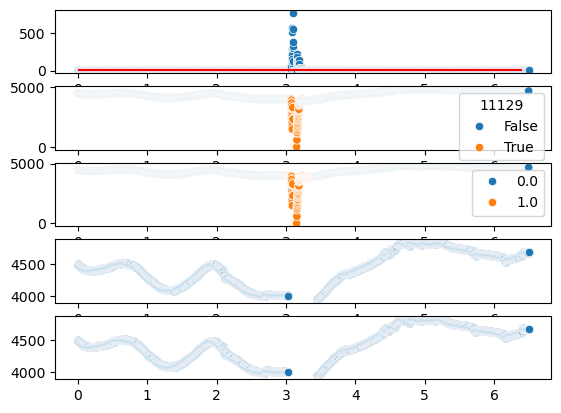

In [24]:
#look at an examplar trial for the blink mask 

try:
    eg = random.randint(0,len(pupFullTrial_raw))
    deBlink(rawPup = pupFullTrial_raw.iloc[eg,1:].astype(float),timestamp = np.linspace(0,included/1000,len(pupFullTrial_raw.iloc[eg,1:])),
                                                borderlenBef= 0.05, borderlenAft = 0.2,minAllowedPup = 2000,
                                                clusterLapse = 0.05, madThreshold = 10,plotSteps=True)#returnMask = True,
except:
    pass

## clean eye movement data

In [121]:

if pupFullTrial_raw.shape[0] != 0:

    """generate the gaze mask, to filter out """
    #also return the blink mask; the mask have a high positive rate, i set the mad threshold (mad = 12) to be higher to 
    #decrease the false positive
    maskClean = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,included/1000,len(x)),
                                                borderlenBef= 0.05, borderlenAft = 0.05,minAllowedPup = 2000,
                                                clusterLapse = 0.03, madThreshold = 12,returnMask = True),axis = 1,raw = True)
    maskClean.insert(0,'TRIALID',pupFullTrial_raw.TRIALID)

    #find trials that are in both saccfull and in mask (this is just a safty check)
    sharedTrl = list(set(saccFullTrial_x_raw.TRIALID) & set(maskClean.TRIALID))
    gazeMask = maskClean[maskClean.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
    stdmask2 = stdmask[stdmask.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

    #further filter by the pupil std mask
    gazeMask.iloc[:,1:] = pd.DataFrame( gazeMask.iloc[:,1:].values.astype(bool)|
                                       stdmask2.iloc[:,1:].values.astype(bool))#cleanTwiceMask.iloc[:,1:].values.astype(bool) |

    saccTemp_x = saccFullTrial_x_raw[saccFullTrial_x_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
    saccTemp_y = saccFullTrial_y_raw[saccFullTrial_y_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

    #sanity check, the trial label should be the same, if not raise error
    if (sum(gazeMask.TRIALID != saccTemp_x.TRIALID) == 0) & (sum(gazeMask.TRIALID != saccTemp_y.TRIALID) == 0):
        #put the mask on
        saccTemp_x.iloc[:,1:] = saccTemp_x.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
        saccTemp_y.iloc[:,1:] = saccTemp_y.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
    else:
        raise('TRIALID mismatch between saccade raw and saccade mask')
    
    #aggregate the sacc temp x and y dfs
    saccTemp_x['axis'] = 'x'
    saccTemp_y['axis'] = 'y'
    saccTemp = pd.concat([saccTemp_x,saccTemp_y]).reset_index(drop = True)

    # drop the useless trials （呆滞的目光，蹒跚的步伐，this man is no use to us）
    trlsKept = pupClean.TRIALID
    saccTemp = saccTemp[saccTemp.TRIALID.isin(trlsKept)].reset_index()

    """interpolation"""
    #anti-aliasing for interpolation
    saccTemp2 = saccTemp.iloc[:,1:].rolling(11,min_periods=1,center  = True,axis =1).mean()

    #interpolation of gaze data
    x = np.linspace(0,5,included)
    saccClean = saccTemp2.iloc[:,:included].apply(lambda y: linearInterpolate(x,y,method='nearest'),axis = 1,raw = True)
    saccClean.insert(0,'TRIALID',saccTemp.TRIALID)
    saccClean.insert(0,'axis',saccTemp.axis)
    saccClean.set_index(['axis'],inplace=True)

    """rejecting trials"""
    #drop trials with all null
    nullTrls = saccClean[(saccClean.iloc[:,500:-500].isnull().sum(axis = 1)) >= (0.2* 5500)].TRIALID
    saccClean = saccClean[~saccClean.TRIALID.isin(nullTrls)]


In [ ]:
saccFullTrial_x_raw.shape,saccClean.shape[0]/2

In [ ]:

try:
    fig,ax = plt.subplots(nrows =4,sharex=True)
    randTrl = random.choice(saccClean.TRIALID.unique())
    saccRAWX = saccFullTrial_x_raw[saccFullTrial_x_raw.TRIALID == randTrl].iloc[0,1:6501]
    trlX = saccTemp_x[saccTemp_x.TRIALID == randTrl].iloc[0,1:6501]
    trlY = saccTemp_y[saccTemp_y.TRIALID == randTrl].iloc[0,1:6501]
    
    ax[2].plot(np.linspace(0,6.5,len(trlX)),trlX)
    ax[3].plot(np.linspace(0,6.5,len(trlY)),trlY)
    ax[1].plot(np.linspace(0,6.5,len(trlY)),gazeMask[gazeMask.TRIALID == randTrl].iloc[0,1:])

    ax[0].plot(np.linspace(0,6.5,len(trlY)),saccRAWX)
except:
    print('please readin files to generate plot')

In [ ]:

try:
    fig,ax = plt.subplots(nrows =3 )
    #randTrl = random.choice(saccClean.TRIALID.unique())
    trlX = saccClean[saccClean.TRIALID == randTrl].loc['x'][1:]
    trlY = saccClean[saccClean.TRIALID == randTrl].loc['y'][1:]
    pupThis = pupClean[pupClean.TRIALID == randTrl].iloc[0,1:]

    ax[0].plot(np.linspace(0,6.5,len(trlX)),trlX)
    ax[1].plot(np.linspace(0,6.5,len(trlY)),trlY)
    ax[2].plot(np.linspace(0,6.5,len(trlY)),pupThis)
except:
    print('please readin files to generate plot')

In [ ]:
fs(10,5)
try:
    fig,ax = plt.subplots(ncols =2 )
    randTrl = random.choice(saccClean.TRIALID.unique())
    trlX = saccClean[saccClean.TRIALID == randTrl].loc['x'][1:]
    trlY = saccClean[saccClean.TRIALID == randTrl].loc['y'][1:]
    ax[0].scatter(x = trlX.values[2000:3000], y = trlY.values[2000:3000], c=trlX.index[2000:3000].astype(int), cmap='viridis', alpha=0.7)
    ax[1].scatter(trlX.values[3000:5000], trlY.values[3000:5000], c=trlX.index[3000:5000].astype(int), cmap='viridis', alpha=0.7)

    [ax[i].set_ylim(540-270,540+270) for i in range(2)]
    [ax[i].set_xlim(960-270,960+270) for i in range(2)]
except:
    print('please readin files to generate plot')

In [181]:
rejectedCnt = pd.DataFrame(saccClean.TRIALID.unique())
rejectedCnt['subj'] = [ast.literal_eval(i)[0] for i in  rejectedCnt[0] ]

# save raw data

In [183]:
thisBatch = input()

In [184]:
rawGazeFileName_x = f'Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted/gazeRaw_x_{thisBatch}.csv'
rawGazeFileName_y = f'Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted/gazeRaw_y_{thisBatch}.csv'
rawPupFileName = f'Z:/yueying/gazeObject_YueyingDong/pupRaw_formatted/pupRaw_{thisBatch}.csv'

if os.path.exists(rawGazeFileName_x):
    print(f"File exists in folder '{rawGazeFileName_x}'.")
else:
    saccFullTrial_x_raw.to_csv(rawGazeFileName_x)
    saccFullTrial_y_raw.to_csv(rawGazeFileName_y)
    pupFullTrial_raw.to_csv(rawPupFileName)


# save cleaned pupil data

In [25]:
thisBatch = input()
cleanPupFileName = f'Z:/yueying/gazeObject_YueyingDong/results/data/pupClean/cleanPup_{thisBatch}.csv'
if os.path.exists(cleanPupFileName):
        print(f"File exists in folder '{cleanPupFileName}'.")
else:
    pupClean.to_csv(cleanPupFileName)

# save gaze data

In [186]:
#save file, specify a batch name e.g. 301to305
thisBatch = input()
cleanGazeFileName = f"Z:/yueying/gazeObject_YueyingDong/results/data/gazeClean/cleanGaze_{thisBatch}.csv"
if os.path.exists(cleanGazeFileName):
        print(f"File exists in folder '{cleanGazeFileName}'.")
else:
    saccClean.to_csv(cleanGazeFileName)

# save psychopy data

In [187]:
#save psychopy
subj = input() #e.g. 301to305
psyPath = "Z:/yueying/gazeObject_YueyingDong/results/data/psychopy/psyFull_" + subj + ".csv"
if os.path.exists(psyPath):
    print('file exist')
else:
    psyFull.to_csv(psyPath)


# readin gaze data (if applicable)

In [6]:
saccClean = pd.DataFrame()
for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/results/data/gazeClean/*360*.csv'):#360to400
 saccClean = pd.concat([saccClean,pd.read_csv(i).iloc[:,:]],axis = 0)

#saccClean = pd.read_csv('C:/Users/yud070/Desktop/gazeObject_YueyingZoe/data/gazeClean/cleanGaze_306to310.csv')
saccClean.set_index('axis',inplace=True)

In [7]:
psyFull = pd.DataFrame()
for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/results/data/psychopy/*360*.csv'):#360to400
 psyFull = pd.concat([psyFull,pd.read_csv(i).iloc[:,:]],axis = 0)

#saccClean = pd.read_csv('C:/Users/yud070/Desktop/gazeObject_YueyingZoe/data/gazeClean/cleanGaze_306to310.csv')
psyFull = psyFull.reset_index(drop=True)

In [15]:
readRaw = False
thisBatch = '360to400'
rawGazeFileName_x = f'Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted/{thisBatch}/gazeRaw_x_*.csv'
rawGazeFileName_y = f'Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted/{thisBatch}/gazeRaw_y_*.csv'
rawPupFileName = f'Z:/yueying/gazeObject_YueyingDong/pupRaw_formatted/{thisBatch}/pupRaw_*.csv'

if readRaw:
    pupFullTrial_raw = pd.DataFrame()
    saccFullTrial_x_raw = pd.DataFrame()
    saccFullTrial_y_raw = pd.DataFrame()
    
    #readin pupfullraw
    for i in glob.glob(rawPupFileName):
        pupFullTrial_raw = pd.concat([pupFullTrial_raw,pd.read_csv(i).iloc[:,1:]])

    for i in glob.glob(rawGazeFileName_x):
        saccFullTrial_x_raw = pd.concat([saccFullTrial_x_raw,pd.read_csv(i).iloc[:,1:]])

    for i in glob.glob(rawGazeFileName_y):
        saccFullTrial_y_raw = pd.concat([saccFullTrial_y_raw,pd.read_csv(i).iloc[:,1:]])


In [15]:
psyFull[(psyFull.TRIALID.isin(saccClean.TRIALID.unique()))].participant.value_counts()

participant
400.0       319
375.0       319
366.0       319
364.0       318
379.0       318
377.0       318
365.0       317
388.0       317
360.0       317
390.0       316
389.0       316
380.0       316
398.0       314
371.0       314
369.0       313
386.0       310
376.0       309
387.0       308
378.0       308
395.0       307
363.0       307
391.0       305
368.0       302
381.0       302
396.0       299
112430.0    298
370.0       298
373.0       297
399.0       297
374.0       292
393.0       291
392.0       285
367.0       284
362.0       275
385.0       272
394.0       271
383.0       269
382.0       264
397.0       262
384.0       255
372.0       255
Name: count, dtype: int64

In [16]:
saccClean.shape[0]/2,psyFull.shape

(11984.0, (13440, 82))

# get the eyetracking data for simon for image reconstruction

# rerun preprocessing using a slightly updated version

In [17]:
#run the preprocessing if the raw file has been readin
if pupFullTrial_raw.shape[0] != 0:
    """for pupil data, apply the speed filter (dBlink)"""
    #Clean once
    cleanOnce = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                borderlenBef= 0.05, borderlenAft = 0.2,minAllowedPup = 2000,
                                                clusterLapse = 0.05, madThreshold = 10),axis = 1,raw = True)

    #smooth the resulting array using rolling window of size 11
    onceSmooth = cleanOnce.rolling(11,min_periods=1,center  = True,axis =1).mean()

    #second clean, this is to get rid of any residual outlier
    cleanTwice = onceSmooth.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),minAllowedPup = 2000,
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 12),axis =1,raw = True)
    
    #reset Index, add back the trial id
    pupFullTrial = cleanTwice.reset_index(drop = True)
    pupFullTrial.insert(0,'TRIALID',pupFullTrial_raw.TRIALID.values)

    """for pupil data only, mask off data using a size filter"""
    #mask off any pupil data that exceed a median +- n*medianSD threshold for that subject
    sdThreshold = 6
    stdmask = pd.DataFrame()
    temp = pupFullTrial.merge(psyFull[['participant','TRIALID']],how = 'left',
                    left_on='TRIALID', right_on='TRIALID')

    for i in temp.participant.unique():
        tempdf = temp[temp.participant == i]

        #calculate upper/lower bounds
        stdupper = np.nanmedian(tempdf.iloc[:,1:included+1])  + sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
        stdlower = np.nanmedian(tempdf.iloc[:,1:included+1])  - sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
        #create std mask for this subj
        stdmask_temp = (tempdf.iloc[:,1:included+1] > stdupper) | (tempdf.iloc[:,1:included+1] < stdlower)
        stdmask_temp.insert(0,'TRIALID',tempdf.TRIALID)
        
        stdmask = pd.concat([stdmask,stdmask_temp])
    
    # no one cared who i was until I put on the df.mask
    # reject the invalid data that's outside of the threshold
    pupFullTrial.iloc[:,1:] = pupFullTrial.iloc[:,1:].mask(stdmask.iloc[:,1:],np.nan)

  

In [18]:
#keep the trial if it has more than 90% data retained in the period of interest
#trialwise
pupClean = pupFullTrial[(pupFullTrial.iloc[:,500:-500].isnull().sum(axis = 1)) < (0.2* included)] .reset_index(drop = True)

#look at the trial remain
pd.DataFrame([ast.literal_eval(i)[0] for i in pupClean['TRIALID']]).value_counts()


NameError: name 'pupFullTrial' is not defined

In [19]:
320*0.6

192.0

In [20]:
#rerun preprocessing if necessary

if pupFullTrial_raw.shape[0] != 0:

    """generate the gaze mask, to filter out """
    #also return the blink mask; the mask have a high positive rate, i set the mad threshold (mad = 12) to be higher to 
    #decrease the false positive
    maskClean = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,included/1000,len(x)),
                                                borderlenBef= 0.05, borderlenAft = 0.05,minAllowedPup = 2000,
                                                clusterLapse = 0.03, madThreshold = 12,returnMask = True),axis = 1,raw = True)
    maskClean.insert(0,'TRIALID',pupFullTrial_raw.TRIALID)

    #find trials that are in both saccfull and in mask (this is just a safty check)
    sharedTrl = list(set(saccFullTrial_x_raw.TRIALID) & set(maskClean.TRIALID))
    gazeMask = maskClean[maskClean.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
    stdmask2 = stdmask[stdmask.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

    #further filter by the pupil std mask
    gazeMask.iloc[:,1:] = pd.DataFrame( gazeMask.iloc[:,1:].values.astype(bool)|
                                       stdmask2.iloc[:,1:].values.astype(bool))#cleanTwiceMask.iloc[:,1:].values.astype(bool) |

    saccTemp_x = saccFullTrial_x_raw[saccFullTrial_x_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
    saccTemp_y = saccFullTrial_y_raw[saccFullTrial_y_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

    #sanity check, the trial label should be the same, if not raise error
    if (sum(gazeMask.TRIALID != saccTemp_x.TRIALID) == 0) & (sum(gazeMask.TRIALID != saccTemp_y.TRIALID) == 0):
        #put the mask on
        saccTemp_x.iloc[:,1:] = saccTemp_x.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
        saccTemp_y.iloc[:,1:] = saccTemp_y.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
    else:
        raise('TRIALID mismatch between saccade raw and saccade mask')
    
    #aggregate the sacc temp x and y dfs
    saccTemp_x['axis'] = 'x'
    saccTemp_y['axis'] = 'y'
    saccTemp = pd.concat([saccTemp_x,saccTemp_y]).reset_index(drop = True)

    # drop the useless trials （呆滞的目光，蹒跚的步伐，this man is no use to us）
    trlsKept = pupClean.TRIALID
    saccTemp = saccTemp[saccTemp.TRIALID.isin(trlsKept)].reset_index()

    """interpolation"""
    #anti-aliasing for interpolation
    saccTemp2 = saccTemp.iloc[:,1:].rolling(11,min_periods=1,center  = True,axis =1).mean()

    #interpolation of gaze data
    x = np.linspace(0,5,included)
    saccClean = saccTemp2.iloc[:,:included].apply(lambda y: linearInterpolate(x,y,method='nearest'),axis = 1,raw = True)
    saccClean.insert(0,'TRIALID',saccTemp.TRIALID)
    saccClean.insert(0,'axis',saccTemp.axis)
    saccClean.set_index(['axis'],inplace=True)

    """rejecting trials"""
    #drop trials with all null
    nullTrls = saccClean[(saccClean.iloc[:,500:-500].isnull().sum(axis = 1)) >= (0.2* (included-1000))].TRIALID
    saccClean = saccClean[~saccClean.TRIALID.isin(nullTrls)]


please readin files to generate plot


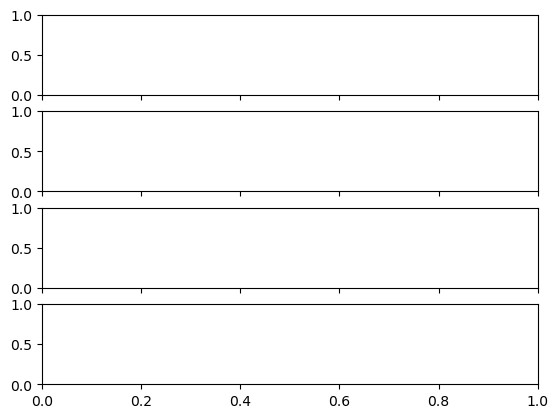

In [21]:

try:
    fig,ax = plt.subplots(nrows =4,sharex=True)
    randTrl = random.choice(saccClean.TRIALID.unique())
    saccRAWX = saccFullTrial_x_raw[saccFullTrial_x_raw.TRIALID == randTrl].iloc[0,1:6501]
    trlX = saccTemp_x[saccTemp_x.TRIALID == randTrl].iloc[0,1:6501]
    trlY = saccTemp_y[saccTemp_y.TRIALID == randTrl].iloc[0,1:6501]
    
    ax[2].plot(np.linspace(0,10,len(trlX)),trlX)
    ax[3].plot(np.linspace(0,10,len(trlY)),trlY)
    ax[1].plot(np.linspace(0,10,len(trlY)),gazeMask[gazeMask.TRIALID == randTrl].iloc[0,1:])

    ax[0].plot(np.linspace(0,10,len(trlY)),saccRAWX)
except:
    print('please readin files to generate plot')

please readin files to generate plot


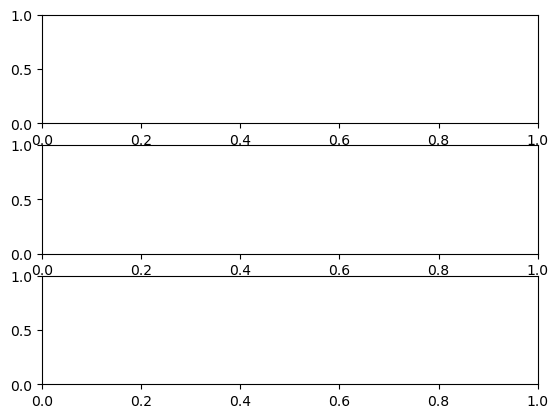

In [22]:

try:
    fig,ax = plt.subplots(nrows =3 )
    #randTrl = random.choice(saccClean.TRIALID.unique())
    trlX = saccClean[saccClean.TRIALID == randTrl].loc['x'][1:]
    trlY = saccClean[saccClean.TRIALID == randTrl].loc['y'][1:]
    pupThis = pupClean[pupClean.TRIALID == randTrl].iloc[0,1:]

    ax[0].plot(np.linspace(0,10,len(trlX)),trlX)
    ax[1].plot(np.linspace(0,10,len(trlY)),trlY)
    ax[2].plot(np.linspace(0,10,len(trlY)),pupThis)
except:
    print('please readin files to generate plot')

# generate heatmap

In [16]:
#get the subjImage id: 
# for each subj
    # for each trial condition
        # get the unique images,

psyFull = psyFull[psyFull.TRIALID.isin(saccClean.TRIALID.unique())]
subjImID_verbal = {} #subject image ID
subjImID_visual = {}

#for each subj
for i in psyFull.participant.unique(): 
    #get the portion of the dataframe for that subj
    thisSubj = psyFull[psyFull.participant == i].reset_index(drop = True)

    #for each unique image of the subj
    for imageThis in thisSubj.stimImage.unique():
        #get the trials corresponding to verval or visual
        TRIALID_verbal = thisSubj[(thisSubj.stimImage == imageThis) & (thisSubj.trlType == 'verbal')].TRIALID.values
        TRIALID_visual = thisSubj[(thisSubj.stimImage == imageThis) & (thisSubj.trlType == 'visual')].TRIALID.values

        #if no trials exist for a condition for an image, don't append it
        if (len(TRIALID_verbal) != 0) and (len(TRIALID_visual) != 0):
            subjImID_verbal[(i,'verbal',imageThis)] = TRIALID_verbal
            subjImID_visual[(i,'visual',imageThis)] = TRIALID_visual

In [40]:
#the image position of the four vertices, in pixels
#in psychopy we used default units 'height', screen size in height units [+-8/9, +-1/2]
#upper right corner of the image: [270. 270.] when using posToPix

imagePosX = [960-270,960+270]
imagePosY = [540-270,540+270]

#
stimStart = 500+1 #2000 + 1
stimEnds = 1500+1 #2000 + 1

delayStart = 2500+500+1#3000 + 1
delayEnds = 6000+1#5000 + 1

In [ ]:
#for each subjImID
#flatten all the data points (for x and y) (for stim and delay)
# get it into the matrix format

#create a heatmap for stim and delay for each subj each unique image
heatmapMatVisual_stim = np.zeros(shape = (len(subjImID_visual),100,100))
heatmapMatVisual_delay = np.zeros(shape = (len(subjImID_visual),100,100))

for n,((subj,cond,image),trlIDs) in enumerate(subjImID_visual.items()):

    thisX_stim = saccClean[saccClean.TRIALID.isin(trlIDs)].iloc[:,stimStart:stimEnds].loc['x',].to_numpy().flatten()
    thisX_delay = saccClean[saccClean.TRIALID.isin(trlIDs)].iloc[:,delayStart:delayEnds].loc['x',].to_numpy().flatten()

    thisY_stim = saccClean[saccClean.TRIALID.isin(trlIDs)].iloc[:,stimStart:stimEnds].loc['y',].to_numpy().flatten()
    thisY_delay = saccClean[saccClean.TRIALID.isin(trlIDs)].iloc[:,delayStart:delayEnds].loc['y',].to_numpy().flatten()

    #in psychopy we used default units 'height', screen size in height units [+-8/9, +-1/2]
    #upper right corner of the image: [270. 270.] when using posToPix
    heatmapMatVisual_stim[n] = plt.hist2d(thisX_stim, thisY_stim, bins = (100,100),range = [imagePosX, imagePosY],
                         density=True,cmap = 'gist_heat',)[0]
    heatmapMatVisual_delay[n] = plt.hist2d(thisX_delay, thisY_delay, bins = (100,100),range = [imagePosX, imagePosY],
                         density=True,cmap = 'gist_heat',)[0]


In [ ]:
#the above cell handles the visual trials, this cell handles the verbal trials
#create a heatmap for stim and delay for each subj each unique image
heatmapMatVerbal_stim = np.zeros(shape = (len(subjImID_verbal),100,100))
heatmapMatVerbal_delay = np.zeros(shape = (len(subjImID_verbal),100,100))

for n,((subj,cond,image),trlIDs) in enumerate(subjImID_verbal.items()):
    thisX_stim = saccClean[saccClean.TRIALID.isin(trlIDs)].iloc[:,stimStart:stimEnds].loc['x',].to_numpy().flatten()
    thisX_delay = saccClean[saccClean.TRIALID.isin(trlIDs)].iloc[:,delayStart:delayEnds].loc['x',].to_numpy().flatten()

    thisY_stim = saccClean[saccClean.TRIALID.isin(trlIDs)].iloc[:,stimStart:stimEnds].loc['y',].to_numpy().flatten()
    thisY_delay = saccClean[saccClean.TRIALID.isin(trlIDs)].iloc[:,delayStart:delayEnds].loc['y',].to_numpy().flatten()

    #in psychopy we used default units 'height', screen size in height units [+-8/9, +-1/2]
    #upper right corner of the image: [270. 270.] when using posToPix
    heatmapMatVerbal_stim[n] = plt.hist2d(thisX_stim, thisY_stim, bins = (100,100),range = [imagePosX, imagePosY],
                         density=True,cmap = 'gist_heat',)[0]
    heatmapMatVerbal_delay[n] = plt.hist2d(thisX_delay, thisY_delay, bins = (100,100),range = [imagePosX, imagePosY],
                         density=True,cmap = 'gist_heat',)[0]

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows = 2)
#see an example
#rows: verbal, visual; columns: stim, delay
ax[0][0].imshow(heatmapMatVerbal_stim[-1].T)
ax[0][1].imshow(heatmapMatVerbal_delay[-1].T)

ax[1][0].imshow(heatmapMatVisual_stim[-1].T)
ax[1][1].imshow(heatmapMatVisual_delay[-1].T)
fig.tight_layout()

# save heatmaps

In [18]:
thisBatch = input() #e.g. 301to305

In [19]:
subjImID_visualPath = f"Z:/yueying/gazeObject_YueyingDong/results/variables/gazeHeatmap/imageID_visual_{thisBatch}.pkl"
subjImID_verbalPath = f"Z:/yueying/gazeObject_YueyingDong/results/variables/gazeHeatmap/imageID_verbal_{thisBatch}.pkl"

hm_visualPath = f"Z:/yueying/gazeObject_YueyingDong/results/variables/gazeHeatmap/hm_visual_{thisBatch}.npy"
hm_verbalPath = f"Z:/yueying/gazeObject_YueyingDong/results/variables/gazeHeatmap/hm_verbal_{thisBatch}.npy"

In [ ]:
# Save id information to a pickle file
# seperately for visual and verbal
if os.path.exists(subjImID_visualPath):
    print(f"File exists")
else:
    for i,k in zip([subjImID_visualPath,subjImID_verbalPath],[subjImID_visual,subjImID_verbal]):
        with open(i, 'wb') as pickle_file:
            pickle.dump(k, pickle_file)



In [197]:
file = open(subjImID_visualPath,'rb')
object_file = pickle.load(file)
file.close()

In [198]:
# save heatmap to .npy file
hm_visual_stimDelay = np.concatenate(([heatmapMatVisual_stim],[heatmapMatVisual_delay]),axis = 0)
hm_verbal_stimDelay = np.concatenate(([heatmapMatVerbal_stim],[heatmapMatVerbal_delay]),axis = 0)

if os.path.exists(hm_visualPath):
    print(f"File exists")
else:
    np.save(hm_visualPath,hm_visual_stimDelay)
    np.save(hm_verbalPath,hm_verbal_stimDelay)

# get gaze variables

In [ ]:
#minimum distance required for a gaze shift to be 
#counted as saccade (5pixel) in either direction
xShiftMin = 8
yShiftMin = 8
task = 'precue'

In [13]:
task = 'precue'
if task == 'retrocue':
    stimStart = 500
    stimEnds = 1500

    delayStart = 3000
    delayEnds = 6000
else:
    
    stimStart = 1500
    stimEnds = 2500

    delayStart = 3000
    delayEnds = 6000

In [14]:
#exp related variables
imagePosX = [960-270,960+270]
imagePosY = [540-270,540+270]

In [15]:
imagePosX,imagePosY

([690, 1230], [270, 810])

In [13]:
"""calculate gaze shift"""

#i used a higher smooth value for y because its is more noisy
smoothSaccX = saccClean.loc['x'].iloc[:,1:].apply(lambda x: smooth(x,window_len=51),axis =1,raw = True)
smoothSaccY = saccClean.loc['y'].iloc[:,1:].apply(lambda x: smooth(x,window_len=51),axis =1,raw = True)


#initialize empty sacc array
shiftDf_relX = np.zeros(shape = smoothSaccX.shape)#relative shift direction in regard to each saccadic movement
shiftDf_relY = np.zeros(shape = smoothSaccY.shape)

# calculate the shift
for i,(x,y) in enumerate(zip(smoothSaccX.values,smoothSaccY.values)):
    shiftDf_relX[i] = findGazeShift2d(x,y,
                           shiftmin = 0,threshold = 6,)
    shiftDf_relY[i] = findGazeShift2d(y,x,
                           shiftmin = 0,threshold = 6)


"""filter out drifts that's too small"""
shiftDf_relX = np.where(((abs(shiftDf_relX) > xShiftMin) | (abs(shiftDf_relY) > yShiftMin)),shiftDf_relX,0)
shiftDf_relY = np.where(((abs(shiftDf_relX) > xShiftMin) | (abs(shiftDf_relY) > yShiftMin)),shiftDf_relY,0)



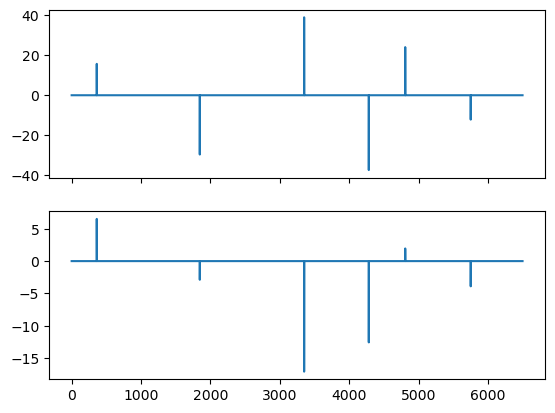

In [14]:
fig,ax = plt.subplots(nrows = 2,sharex=True)
ax[0].plot(shiftDf_relX[4])
ax[1].plot(shiftDf_relY[4])

In [15]:
"""select the epoch of interest: stim, delay"""
#select for x
shiftX_stim = shiftDf_relX[:,stimStart:stimEnds]
shiftX_delay = shiftDf_relX[:,delayStart:delayEnds]
#select for y
shiftY_stim = shiftDf_relY[:,stimStart:stimEnds]
shiftY_delay = shiftDf_relY[:,delayStart:delayEnds]

"""calculate the eucledian distance traveled"""
saccDist_stim = np.sqrt(shiftX_stim**2 + shiftY_stim**2).sum(axis = 1)
saccDist_delay = np.sqrt(shiftX_delay**2 + shiftY_delay**2).sum(axis = 1)

In [15]:
plotExample = True
if task == 'retrocue':
    goodExample = 265
else:
    goodExample = 10954

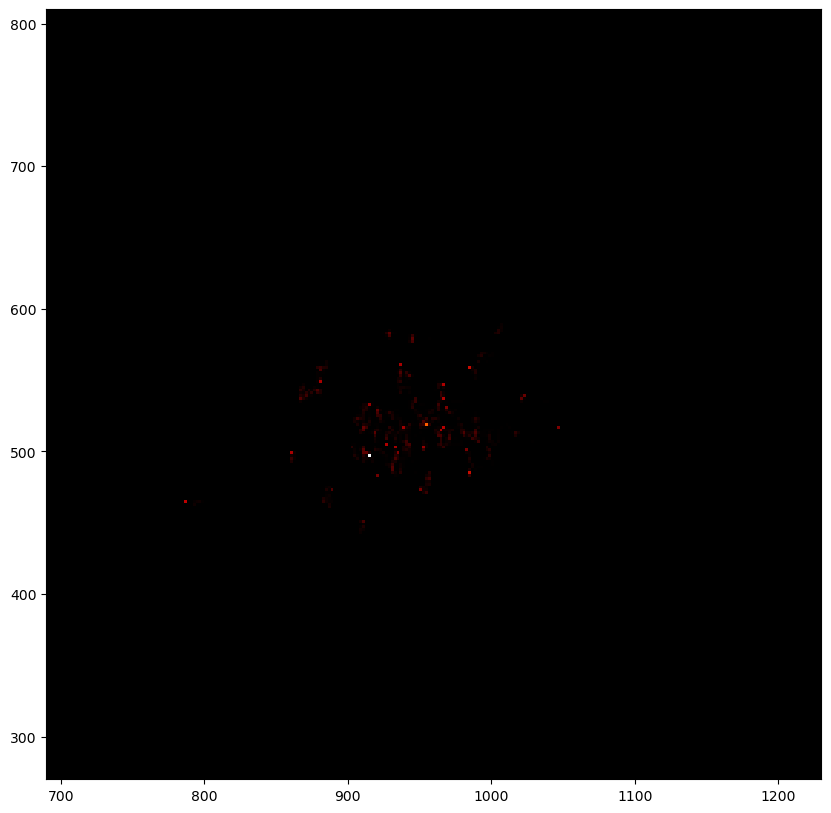

In [17]:
fs(10,10)
#exp related variables
imagePosX = [960-270,960+270]
imagePosY = [540-270,540+270]
bearTrlsAll = psyFull[(psyFull.stimImage == 'images/bear/bear_08s.jpg')&(psyFull.participant == 319)].TRIALID


thisX_stim = saccClean[saccClean.TRIALID.isin(bearTrlsAll)].loc['x'].iloc[:,stimStart:stimEnds].to_numpy().flatten()
thisX_delay = saccClean[saccClean.TRIALID.isin(bearTrlsAll)].loc['x'].iloc[:,delayStart:delayEnds].to_numpy().flatten()

thisY_stim = saccClean[saccClean.TRIALID.isin(bearTrlsAll)].loc['y'].iloc[:,stimStart:stimEnds].to_numpy().flatten()
thisY_delay = saccClean[saccClean.TRIALID.isin(bearTrlsAll)].loc['y'].iloc[:,delayStart:delayEnds].to_numpy().flatten()

#in psychopy we used default units 'height', screen size in height units [+-8/9, +-1/2]
#upper right corner of the image: [270. 270.] when using posToPix
encodingHeatmapEg = plt.hist2d(thisX_stim, thisY_stim, bins = (270,270),range = [imagePosX, imagePosY],
                    density=True,cmap = 'gist_heat',)[0];
delayHeatmapEg = plt.hist2d(thisX_delay, thisY_delay, bins = (270,270),range = [imagePosX, imagePosY],
                    density=True,cmap = 'gist_heat',)[0];

In [18]:
#prep the file for export

shiftDf_relX_tagged = np.hstack([saccClean.loc['x'].TRIALID.values[:,None],shiftDf_relX])
shiftDf_relY_tagged = np.hstack([saccClean.loc['y'].TRIALID.values[:,None],shiftDf_relY])
shiftMat_tagged = np.stack([shiftDf_relX_tagged,shiftDf_relY_tagged]) #first is x, second is y

In [19]:
#subj = input() #e.g.301to305
if task == 'retrocue':
    subj = '360to400'
else:
    subj = '311to352'
workspace_path = f'Z:/yueying/gazeObject_YueyingDong/results/variables/sacc/gazeShift_{subj}.npy'


# check if the file exists, if not, save

if os.path.exists(workspace_path):
    print('file exists')
    pass
else:
    np.save(workspace_path,shiftMat_tagged)

# prepare data for scan path

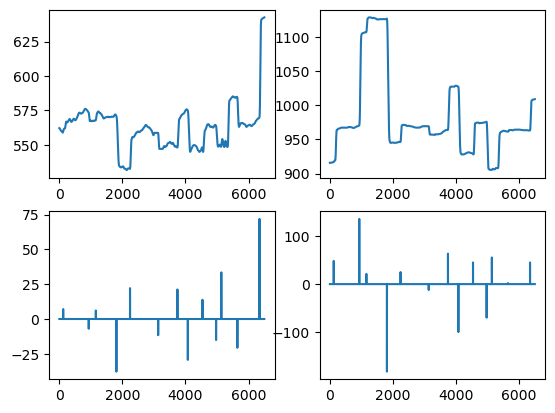

In [107]:
#look at one trial example, x and y channel
eg = np.random.randint(5000)
fig,ax = plt.subplots(nrows = 2,ncols=2)
ax[0][0].plot(np.arange(included),smoothSaccY.iloc[eg])
ax[1][0].plot(np.arange(included),shiftDf_relY[eg])

ax[0][1].plot(np.arange(included),smoothSaccX.iloc[eg])
ax[1][1].plot(np.arange(included),shiftDf_relX[eg])


In [106]:
smoothSaccX_stim = smoothSaccX.iloc[:,stimStart:stimEnds]
smoothSaccY_stim = smoothSaccY.iloc[:,stimStart:stimEnds]

smoothSaccX_delay = smoothSaccX.iloc[:,delayStart:delayEnds]
smoothSaccY_delay = smoothSaccY.iloc[:,delayStart:delayEnds]



In [108]:
#the ScanMatch package requirs the data to be stored in x,y,duration format.
#i do this for every trial
fixationArrX_stim = []
fixationArrY_stim = []
fixationDurationEach_stim = []

for q in range(len(smoothSaccX_stim)):
    saccLoc = np.where(shiftDf_relX[q,stimStart:stimEnds]!=0)[0]
    try:
        if saccLoc[0] != 0: 
            saccLoc = np.r_[0,saccLoc,]
        if saccLoc[-1] != delayStart-stimStart:
            saccLoc = np.r_[saccLoc,delayStart-stimStart]
    except IndexError:
        pass 
    fixationArrX_stim.append([int(smoothSaccX_stim.iloc[q,i:j].mean()) for i,j in zip(saccLoc[:-1],saccLoc[1:]) ])
    fixationArrY_stim.append([int(smoothSaccY_stim.iloc[q,i:j].mean()) for i,j in zip(saccLoc[:-1],saccLoc[1:]) ])
    fixationDurationEach_stim.append((saccLoc[1:] - saccLoc[:-1])/1000)

In [109]:
#the ScanMatch package requirs the data to be stored in x,y,duration format.
#i do this for every trial
fixationArrX_delay = []
fixationArrY_delay = []
fixationDurationEach_delay = []

for q in range(len(smoothSaccX_delay)):
    saccLoc = np.where(shiftDf_relX[q,delayStart:delayEnds]!=0)[0]
    try:
        if saccLoc[0] != 0: 
            saccLoc = np.r_[0,saccLoc,]
        if saccLoc[-1] != delayEnds-delayStart:
            saccLoc = np.r_[saccLoc,delayEnds-delayStart]
    except IndexError:
        pass 
    fixationArrX_delay.append([int(smoothSaccX_delay.iloc[q,i:j].mean()) for i,j in zip(saccLoc[:-1],saccLoc[1:]) ])
    fixationArrY_delay.append([int(smoothSaccY_delay.iloc[q,i:j].mean()) for i,j in zip(saccLoc[:-1],saccLoc[1:]) ])
    fixationDurationEach_delay.append((saccLoc[1:] - saccLoc[:-1])/1000)

In [110]:
#fix the trial label, otherwise matlab will throw an error, now the trial label looks like t_111_1_1
trlLabels = ['t' + i.replace("'",'').replace("(",'').replace(")",'').replace(", ",'_').replace(" ",'') for i in saccClean.loc['x'].TRIALID.values]

mat_stim = [np.vstack((i,k,j)).T for i,k,j in zip(fixationArrX_stim,fixationArrY_stim,fixationDurationEach_stim)] #formatting
mat_delay = [np.vstack((i,k,j)).T for i,k,j in zip(fixationArrX_delay,fixationArrY_delay,fixationDurationEach_delay)] #formatting

outMat_stim = dict(zip(trlLabels,mat_stim)) 
outMat_delay = dict(zip(trlLabels,mat_delay)) 


In [114]:
temp = pd.DataFrame(saccClean.loc['x'].TRIALID)
temp['subj'] = [ast.literal_eval(i)[0]  for i in temp.TRIALID]

In [115]:
workspace_path = 'Z:/yueying/gazeObject_YueyingDong/results/variables/scanMatchVariables/'

In [116]:
indexer = np.r_[0,temp.subj.value_counts().sort_index().cumsum().values]
for n,(indexStart,indexEnds) in enumerate(zip(indexer[:-1],indexer[1:])):
    

    a = dict(list(outMat_stim.items())[indexStart:indexEnds])
    b = dict(list(outMat_delay.items())[indexStart:indexEnds])
    c = trlLabels[indexStart:indexEnds]

    subj = c[0][1:4]
    outMat_stim_name = str(subj)+ '_scanMatch_stim.mat'
    outMat_delay_name = str(subj)+ '_scanMatch_delay.mat'

    print(subj,len(c))

    # check if the file exists, if not, save
    for pathName, item in zip(
        [outMat_stim_name,outMat_delay_name],
        [a,b]):
        if os.path.exists(workspace_path+ pathName):
            #print(f"File {pathName} exists")
            pass
        else:
            scipy.io.savemat(workspace_path+ pathName,item)
            np.save('Z:/yueying/gazeObject_YueyingDong/results/variables/scanMatchTrlID/360to400New/' +str(subj) +'_saccTrlIDs.npy',c)


112 300
360 319
362 275
363 308
364 319
365 319
366 319
367 287
368 303
369 313
370 306
371 316
372 259
373 298
374 293
375 319
376 313
377 319
378 312
379 319
380 317
381 305
382 269
383 272
384 262
385 281
386 310
387 311
388 319
389 316
390 317
391 309
392 288
393 300
394 282
395 310
396 299
397 268
398 318
399 298
400 319


# tag trials

In [102]:
trlInfo = pd.DataFrame()
for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/results/data/psychopy/*.csv')[-1:]:
 trlInfo = pd.concat([trlInfo,pd.read_csv(i)[['participant','TRIALID','stimImage','trlType']]],axis = 0)
trlInfo['stimImage'] = [i.split('/')[-1] for i in trlInfo.stimImage]
trlInfo = trlInfo[trlInfo.TRIALID.isin(temp.TRIALID)]


In [105]:
order_mapping = {value: idx for idx, value in enumerate(temp['TRIALID'])}

# Add a temporary column in trlInfo to indicate the order based on temp
trlInfo['order'] = trlInfo['TRIALID'].map(order_mapping)

# Reorder trlInfo based on the 'order' column
trlInfo_sorted = trlInfo.sort_values('order').drop(columns='order')



In [ ]:
orderPath = f'Z:/yueying/gazeObject_YueyingDong/results/variables/scanMatchTrlOrdering/trlOrdering{thisBatch}.csv'
if os.path.exists(orderPath):
    print('file exist')
    pass
else:
    print('file does not exist, writing...')
    trlInfo_sorted.reset_index().to_csv(orderPath)